In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV, StratifiedKFold,cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, PolynomialFeatures, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import ols
from statsmodels.api import OLS
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import pickle


### Importation du CSV et création du dataframe

In [2]:
df = pd.read_csv("assurance.csv")
df=df.drop_duplicates()

# df.loc[df['bmi'] < 18.5 , 'grade'] = 'underweight'
# df.loc[df['bmi'].between(18.5, 25, 'left'), 'grade'] = 'good'
# df.loc[df['bmi'].between(25, 30, 'both'), 'grade'] = 'overweight'
# df.loc[df['bmi'] > 30, 'grade'] = 'obesity'
# df.drop('bmi',axis=1, inplace=True)

df.loc[df['bmi'] < 18.5 , 'grade'] = 'underweight'
df.loc[df['bmi'].between(18.5, 25, 'left'), 'grade'] = 'good'
df.loc[df['bmi'].between(25, 30, 'both'), 'grade'] = 'overweight'
df.loc[df['bmi'] > 30, 'grade'] = 'obesity'
df.drop('bmi',axis=1, inplace=True)

# df[['grade','indicateur']].head(50)



### Création de la matrice X (variables explicatives) et de la série y (variable cible)

In [3]:
X = df.drop(['charges'], axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, train_size=0.85, random_state=42 ,stratify=X[['smoker','grade']])
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)



-0.0003055935779685548

Suite à l'analyse de données nous avons décidé de supprimer la série "région" étant donné qu'elle n'est pas corrélée à la variable cible 

### Création d'un pipeline afin d'encoder notre model ElasticNet

In [4]:
transformer = make_column_transformer(
    (OneHotEncoder(),['sex','smoker','region','grade']),
    (StandardScaler(),['age','children'])
    )

In [5]:
onehot = OneHotEncoder(drop="if_binary")
std = StandardScaler()
num_pipe = make_pipeline(StandardScaler(),)
onehot_col_std = make_column_transformer(
    (onehot, ['sex', 'region', 'smoker', 'grade']),
    (num_pipe, ['age',  'children'])
    )
preprocessing_poly_std = make_pipeline(onehot_col_std, PolynomialFeatures())
lr = LinearRegression()
# lr_pipe = make_pipeline(preprocessing_poly, lr)
lr_pipe_std = make_pipeline(preprocessing_poly_std, lr)
lr_pipe_std.fit(X_train, y_train)
cross_validate(lr_pipe_std, X_train, y_train, cv=5)['test_score'].mean()

-5.528246600102938e+19

In [6]:

model_lr = make_pipeline(transformer,PolynomialFeatures(2),LinearRegression())
model_lr.fit(X_train,y_train)


cross_val=cross_validate(model_lr, X_train, y_train, cv=5, scoring='r2')
cross_val['test_score'].mean()

-4.0758166925820455e+21

Nous avons besoin d'encoder les variables catégorielles (OneHotEncoder) pour passer des strings à des integer
La standardisation est utilisée pour converger vers la meilleure solution 

#### Entrainement de notre model sur le X_train

In [7]:
model = make_pipeline(transformer,PolynomialFeatures(),ElasticNet(random_state=42 ))
model.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['sex', 'smoker', 'region',
                                                   'grade']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'children'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('elasticnet', ElasticNet(random_state=42))])

In [8]:
cross_val=cross_validate(model, X_train, y_train,cv=5)
cross_val['test_score'].mean()

0.7200690742771397

Nous obtenons une score de 65 , après la cross validation, pour notre modele avec les valeurs par defaut des paramètres de notre modele.

#### Utilisation d'un RandomizeSearch afin d'avoir un ordre d'idée de l'hyperparamètre d'ElasticNet à modifier pour améliorer notre model

In [9]:
param_search = {'elasticnet__alpha':np.linspace(0,100,500),'elasticnet__l1_ratio':[1],'polynomialfeatures__degree':[1,2]}
random_search = RandomizedSearchCV(model, param_distributions=param_search, n_iter=100, cv=5, random_state=42)
random_search.fit(X_train, y_train)
print(random_search.best_params_)

/home/anas/miniconda3/envs/datascience_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.395e+08, tolerance: 1.332e+07
  model = cd_fast.enet_coordinate_descent(
/home/anas/miniconda3/envs/datascience_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.455e+07, tolerance: 1.367e+07
  model = cd_fast.enet_coordinate_descent(
/home/anas/miniconda3/envs/datascience_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

{'polynomialfeatures__degree': 2, 'elasticnet__l1_ratio': 1, 'elasticnet__alpha': 85.97194388777555}


#### Utilisation d'un GridSearch afin d'obtenir l'hyperparamètre d'ElasticNet( centré autour de la valeur donnée par le RandomizeSearch) le plus efficient

In [10]:
params = {'elasticnet__alpha':np.linspace(82,87,100)}
grid=GridSearchCV(random_search.best_estimator_, param_grid=params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region',
                                                                          'grade']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'children'])])),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('elasticnet',
                                        ElasticNet(alpha=85.97194388777555,
                                                   l1_ratio=1,
                                                   random_state=42))]),
             par...
       85.53535354, 85.58585859, 85.63636364, 85.68686869, 85.73737374,
       85.78787879, 85.83838384, 85.88888889, 85.93939394, 85.98989899,
       86.04040404, 86.09090909, 86.14141414, 86.19191919, 86.24242424,
       86.29292929, 86.34343434, 86.39393939, 86.44444444, 86.49494949,
       86.54545455, 86.5959596 , 86.64646465, 86.6969697 , 86.74747475,
       86.7979798 , 86.84848485, 86.8989899 , 86.94949495, 87.        ])},
             scoring='r2')

Valeur de l'hyperparamètre alpha déterminée grâce au GridSearch

In [11]:
grid.best_params_
# {'elasticnet__alpha': 27.0}

{'elasticnet__alpha': 85.03030303030303}

Application du meilleur hyperparamètre (trouvé) à notre model 

In [12]:
best_model= grid.best_estimator_

In [13]:
grid.best_score_

0.8601806781089794

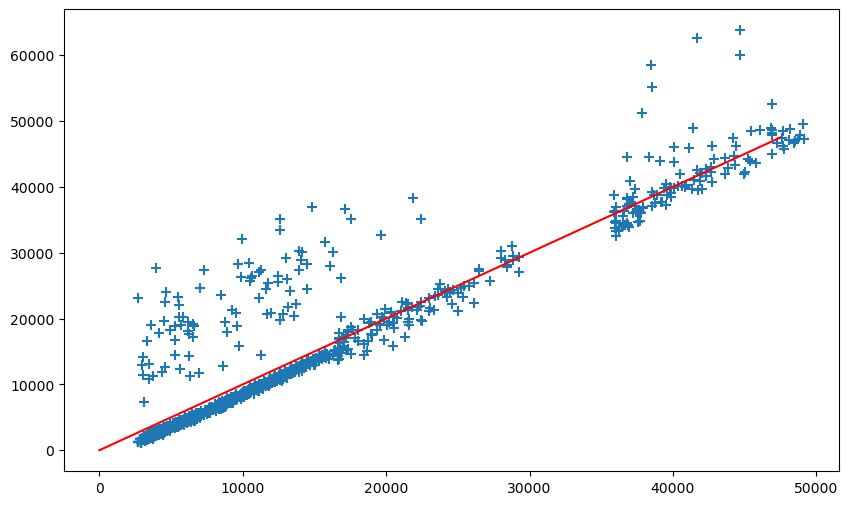

In [14]:
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_train)
plt.subplots(figsize=(10, 6))
plt.scatter(y_pred,y_train,marker="+",s=50)
plt.plot(np.arange(max(y_test.values)), np.arange(max(y_test.values)), '-', color='r')
plt.show()


#### Présentation des scores R2 de notre modèle

In [15]:
best_model.score(X_train,y_train)

0.8701146096433207

Après l'application des hyperparamètres, on peut observer que notre modele s'est bien améliorer! On obtient un score de 80!

## Utilsation de la regression lineaire afin de comparer avec notre model ElasticNet

In [16]:

model_lr = make_pipeline(transformer,PolynomialFeatures(),LinearRegression())
model_lr.fit(X_train,y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['sex', 'smoker', 'region',
                                                   'grade']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'children'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [17]:
cross_val=cross_validate(model_lr, X_train, y_train, cv=5)
cross_val['test_score'].mean()

-4.0758166925820455e+21

In [18]:
a=make_pipeline(transformer,PolynomialFeatures()).fit_transform(X_train)
a_columns= transformer.get_feature_names_out()
adf= pd.DataFrame(a)#.set_index(y_train.index)
# adf.columns = a_columns
adf


,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-0.000000,0.000000,0.0,-0.0,0.0,0.087304,-0.228019,0.595536
1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.555369,-0.060038,0.0,0.0,-0.0,0.308434,-0.033343,0.003605
2,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.000000,-0.000000,0.0,-0.0,-0.0,0.871616,0.056052,0.003605
3,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,-1.146314,-0.891786,0.0,-0.0,-0.0,1.314036,1.022267,0.795283
4,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,-0.000000,-0.000000,0.0,-0.0,-0.0,2.044694,1.275190,0.795283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.117415,0.264433,0.595536
1132,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,-0.000000,-0.000000,0.0,-0.0,-0.0,0.422487,0.039024,0.003605
1133,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.977427,1.085187,0.595536
1134,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.271755,-0.891786,0.0,0.0,-0.0,0.073851,-0.242347,0.795283


In [19]:
X

,age,sex,children,smoker,region,grade
0,19,female,0,yes,southwest,overweight
1,18,male,1,no,southeast,obesity
2,28,male,3,no,southeast,obesity
3,33,male,0,no,northwest,good
4,32,male,0,no,northwest,overweight
...,...,...,...,...,...,...
1333,50,male,3,no,northwest,obesity
1334,18,female,0,no,northeast,obesity
1335,18,female,0,no,southeast,obesity
1336,21,female,0,no,southwest,overweight


In [20]:
y_train

93       5729.00530
818     23401.30575
141      3490.54910
875      2690.11380
362     13844.50600
           ...     
184      7731.42710
307      4151.02870
278     12928.79110
501      6837.36870
1177     6496.88600
Name: charges, Length: 1136, dtype: float64

## Droite de regression linéaire

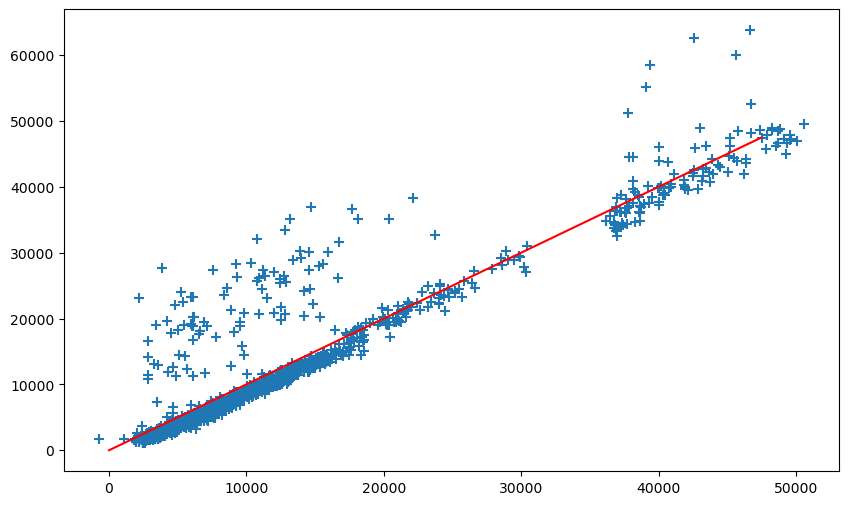

In [21]:
model_lr.fit(X_train,y_train)
y_pred = model_lr.predict(X_train)
plt.subplots(figsize=(10, 6))
plt.scatter(y_pred,y_train,marker="+",s=50)
plt.plot(np.arange(max(y_test.values)), np.arange(max(y_test.values)), '-', color='r')
plt.show()


On remarque que la regression lineaire obtient un meilleur resultat qu'ElasticNet

## Essayons d'ameliorer notre modele en utilisant la distance de Cook

Notre ElasticNet ,en ayant supprimé ces valeurs atypiques influentes, s'ameliore!

In [22]:
X_cook= transformer.transform(X_train)
X_cook_columns= transformer.get_feature_names_out()
newdf= pd.DataFrame(X_cook).set_index(y_train.index)
newdf.columns = X_cook_columns

X_cook=sm.add_constant(X_cook)
model_c = OLS(y_train , X_cook).fit()
influence = model_c.get_influence().cooks_distance[0]
cooks_distance = influence

analyse=X_train.copy()
analyse['dcooks'] = influence
n= X_train.shape[0]
p = X_train.shape[1]
seuil_dcook = 4/n

residual_indice=analyse[analyse['dcooks']>seuil_dcook].index
residual_indice.size

X_train.drop(residual_indice, inplace=True)
y_train.drop(residual_indice, inplace=True)

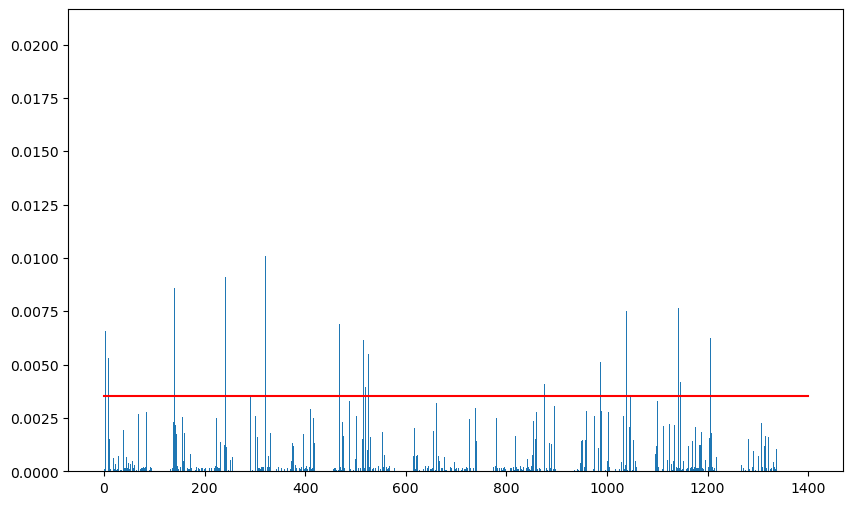

In [23]:
plt.figure(figsize=(10,6))
plt.bar(analyse.index, analyse['dcooks'])
# plt.xticks(np.arange(0, 200, step=1))
# plt.xlabel('Observation')
# plt.ylabel('Leviers')
plt.plot([0, 1400], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [24]:
cross_val=cross_validate(model_lr, X_train, y_train,cv=5)
print(cross_val)
cross_val['test_score'].mean()

{'fit_time': array([0.01038098, 0.01141143, 0.00808883, 0.00879788, 0.00867438]), 'score_time': array([0.00312328, 0.00353241, 0.00353098, 0.00377202, 0.00284934]), 'test_score': array([0.93421027, 0.89895968, 0.91883533, 0.91257545, 0.95051346])}


0.9230188381414901

In [25]:
cross_val=cross_validate(model_lr, X_train, y_train,scoring='neg_root_mean_squared_error' ,cv=5)
print(cross_val)
cross_val['test_score'].mean()

{'fit_time': array([0.03231668, 0.00935507, 0.00914454, 0.00832582, 0.00847769]), 'score_time': array([0.00466847, 0.00296402, 0.00350022, 0.00333238, 0.00351572]), 'test_score': array([-2950.46771145, -3533.26955177, -2806.49643801, -3346.38584386,
       -2970.23083575])}


-3121.3700761660652

In [26]:
grid.fit(X_train, y_train)
best_model= grid.best_estimator_
grid.best_score_

0.9248044749028553

In [27]:
best_model[:-1].get_feature_names_out()

array(['1', 'onehotencoder__sex_female', 'onehotencoder__sex_male',
       'onehotencoder__smoker_no', 'onehotencoder__smoker_yes',
       'onehotencoder__region_northeast',
       'onehotencoder__region_northwest',
       'onehotencoder__region_southeast',
       'onehotencoder__region_southwest', 'onehotencoder__grade_good',
       'onehotencoder__grade_obesity', 'onehotencoder__grade_overweight',
       'onehotencoder__grade_underweight', 'standardscaler__age',
       'standardscaler__children', 'onehotencoder__sex_female^2',
       'onehotencoder__sex_female onehotencoder__sex_male',
       'onehotencoder__sex_female onehotencoder__smoker_no',
       'onehotencoder__sex_female onehotencoder__smoker_yes',
       'onehotencoder__sex_female onehotencoder__region_northeast',
       'onehotencoder__sex_female onehotencoder__region_northwest',
       'onehotencoder__sex_female onehotencoder__region_southeast',
       'onehotencoder__sex_female onehotencoder__region_southwest',
       'on

In [28]:
coef=best_model[-1].coef_
coef

array([ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -1.19831404e+04,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  4.85880607e+02,  0.00000000e+00,
       -0.00000000e+00,  3.68041581e+03,  4.75283033e+02,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -8.26643782e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  9.04676939e+00, -4.17104752e+02,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -3.60950881e+02,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        3.39100769e-01,  

In [29]:
coef_df= pd.DataFrame(coef, columns=['coef'] ,index=best_model[:-1].get_feature_names_out())
coef_df

,coef
1,0.000000
onehotencoder__sex_female,0.000000
onehotencoder__sex_male,-0.000000
onehotencoder__smoker_no,-11983.140376
onehotencoder__smoker_yes,0.000000
...,...
onehotencoder__grade_underweight standardscaler__age,0.000000
onehotencoder__grade_underweight standardscaler__children,0.000000
standardscaler__age^2,519.255974
standardscaler__age standardscaler__children,0.000000


In [30]:
coef_df[coef_df['coef'] != 0].shape[0]

15

In [31]:
coef_df[coef_df['coef'] != 0]


,coef
onehotencoder__smoker_no,-11983.140376
onehotencoder__grade_obesity,485.880607
standardscaler__age,3680.415814
standardscaler__children,475.283033
onehotencoder__sex_male onehotencoder__smoker_no,-8.266438
onehotencoder__sex_male standardscaler__children,9.046769
onehotencoder__smoker_no^2,-417.104752
onehotencoder__smoker_no onehotencoder__region_southwest,-360.950881
onehotencoder__smoker_no standardscaler__age,0.339101
onehotencoder__smoker_no standardscaler__children,157.261384


In [32]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = newdf.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [vif(newdf, i) for i in range(len(newdf.columns))]

print(vif_data)

# newdf

                             feature       VIF
0          onehotencoder__sex_female       inf
1            onehotencoder__sex_male       inf
2           onehotencoder__smoker_no       inf
3          onehotencoder__smoker_yes       inf
4    onehotencoder__region_northeast       inf
5    onehotencoder__region_northwest       inf
6    onehotencoder__region_southeast       inf
7    onehotencoder__region_southwest       inf
8          onehotencoder__grade_good       inf
9       onehotencoder__grade_obesity       inf
10   onehotencoder__grade_overweight       inf
11  onehotencoder__grade_underweight       inf
12               standardscaler__age  1.015708
13          standardscaler__children  1.007370


/home/anas/miniconda3/envs/datascience_env/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [38]:
with open('model.pkl', 'wb') as file:
  pickle.dump(best_model, file)